In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import functools

In [3]:
# leer las trayectorias generadas
import h5py

data_file = "trayectorias.h5"

with h5py.File(data_file, "r") as hf:
    trayectorias = hf["trayectorias"][:]

# Asegúrate de que las trayectorias se ajusten a tus necesidades específicas
# Si es necesario, puedes transformar los datos en tensores TensorFlow
trayectorias = tf.constant(trayectorias, dtype=tf.float32)


trayectorias[0]

<tf.Tensor: shape=(2, 300), dtype=float32, numpy=
array([[-1.25865555e+00, -9.77387309e-01, -6.78268313e-01,
        -3.55390608e-01, -6.64392533e-03,  3.65492225e-01,
         7.53243744e-01,  1.13734984e+00,  1.49367452e+00,
         1.79739988e+00,  2.02956629e+00,  2.18634725e+00,
         2.27248311e+00,  2.30062056e+00,  2.28597069e+00,
         2.23873663e+00,  2.16727090e+00,  2.07709336e+00,
         1.97135079e+00,  1.85201073e+00,  1.71991539e+00,
         1.57509196e+00,  1.41703534e+00,  1.24472558e+00,
         1.05694628e+00,  8.51811171e-01,  6.26987040e-01,
         3.81266445e-01,  1.14597045e-01, -1.71918273e-01,
        -4.74914581e-01, -7.84551382e-01, -1.08745039e+00,
        -1.36792767e+00, -1.60888922e+00, -1.79871917e+00,
        -1.93274152e+00, -2.01221037e+00, -2.04414368e+00,
        -2.03714871e+00, -1.99844933e+00, -1.93422818e+00,
        -1.84922826e+00, -1.74624717e+00, -1.62705803e+00,
        -1.49256408e+00, -1.34296203e+00, -1.17780423e+00,
      

cambio dastrico al formato del codigo;
debido a que el modelo usara el tiempo y la condicion de borde sera aprendida, unicamente podemos utilizar una sola trayectoria, ergo:


In [21]:
trayectorias[0,:,:]

# N total of data
N = trayectorias[0,:,:].shape[1]

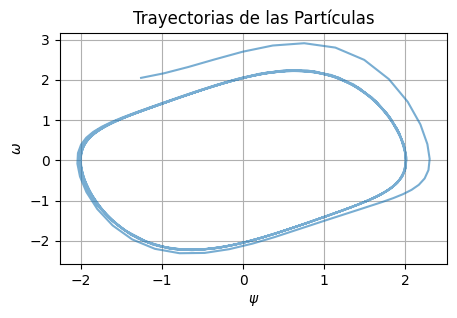

In [22]:
def plot_trayectoria(trayectorias, N):
    plt.figure(figsize=(5, 3))
    if len(trayectorias.shape) == 2:
        print('one data point')
        plt.plot(trayectorias[0], trayectorias[1], alpha=0.6)

    else:
        for i in range(N):
            plt.plot(trayectorias[i][0], trayectorias[i][1], alpha=0.6)
    plt.xlabel(r'$\psi$')
    plt.ylabel(r'$\omega$')
    plt.title('Trayectorias de las Partículas')
    plt.grid()
    plt.show()

plot_trayectoria(trayectorias, 1)

debido a esto,
- validation_data: es un instante superior de tiempo no visto
- test_data: es un instante superior de tiempo no visto

In [26]:
train_index = 250
val_index = 270

train_data = trayectorias[0, :, :train_index]
val_data = trayectorias[0, :, train_index:val_index]
test_data = trayectorias[0, :, val_index:]

print("Forma del conjunto de entrenamiento: ", train_data.shape)
print("Forma del conjunto de validación: ", val_data.shape)
print("Forma del conjunto de prueba: ", test_data.shape)


X_train = train_data[0,:]
P_train = train_data[0,:]

X_train.shape[0]

Forma del conjunto de entrenamiento:  (2, 250)
Forma del conjunto de validación:  (2, 20)
Forma del conjunto de prueba:  (2, 30)


250

# El modelo

Debido a que este modelo utiliza condiciones iniciales y no las toma como input, significa que el modelo habrá de aprender estas condiciones iniciales,
por tanto solo puede aprender de una curva a la vez


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)

        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        inputs_expanded = tf.expand_dims(inputs, axis=-1) 
        z = self.hidden1(inputs_expanded)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [29]:
t = tf.range(N, dtype=tf.float32)
t_train = t[:train_index]
t_valid = t[train_index:val_index]
t_test = t[val_index:]

In [39]:
params = {'mu': 2.0, 'position_weight': 10.0, 'momentum_weight': 5.0, 'phys_weight': 1.0}
X_target = X_train
P_target = P_train

@tf.function
def physics_loss(inputs, outputs):
    mu = params.get('mu', 2.0)
    position_weight = params.get('position_weight', 10)
    momentum_weight = params.get('momentum_weight', 5)
    data_weight = params.get('data_weight', 1)
    phys_weight = params.get('phys_weight', 1)

    _inputs = tf.expand_dims(inputs, axis=-1)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(_inputs)
        X_predicted = model(_inputs)
        dx_dt = tape.gradient(X_predicted, _inputs)
        d2x_dt2 = tape.gradient(dx_dt, _inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted
    
    # Physics loss
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))
    
    loss = phys_weight * tf.reduce_mean(tf.square(f))
    loss += position_weight * position_loss
    loss += momentum_weight * momentum_loss
    
    # #Data loss (optional, depending on your needs)
    # data_loss = data_weight * tf.reduce_mean(tf.square(X_predicted - X_target))
    # loss += data_loss
    
    return loss


In [43]:
model = VanderPolModel()
inputs = t_train
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=[physics_loss])
history = model.fit(inputs, X_train, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1130, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\optimizer.py", line 1222, in apply_gradients
        grads_and_vars = self.aggregate_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\optimizer.py", line 1184, in aggregate_gradients
        return optimizer_utils.all_reduce_sum_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\utils.py", line 33, in all_reduce_sum_gradients
        filtered_grads_and_vars = filter_empty_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['vander_pol_model_8/dense_40/kernel:0', 'vander_pol_model_8/dense_40/bias:0', 'vander_pol_model_8/dense_41/kernel:0', 'vander_pol_model_8/dense_41/bias:0', 'vander_pol_model_8/dense_42/kernel:0', 'vander_pol_model_8/dense_42/bias:0', 'vander_pol_model_8/dense_43/kernel:0', 'vander_pol_model_8/dense_43/bias:0', 'vander_pol_model_8/dense_44/kernel:0', 'vander_pol_model_8/dense_44/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'vander_pol_model_8/dense_40/kernel:0' shape=(1, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_40/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_41/kernel:0' shape=(64, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_41/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_42/kernel:0' shape=(64, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_42/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_43/kernel:0' shape=(64, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_43/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_44/kernel:0' shape=(64, 1) dtype=float32>), (None, <tf.Variable 'vander_pol_model_8/dense_44/bias:0' shape=(1,) dtype=float32>)).


In [41]:
history.history

{'loss': [26.786300659179688,
  16.487895965576172,
  12.373407363891602,
  9.806573867797852,
  9.309324264526367,
  9.01572322845459,
  9.270089149475098,
  8.623286247253418,
  9.434666633605957,
  9.45088005065918]}

In [32]:

model = VanderPolModel()
inputs = t
num_epochs = 200

optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(X_target, P_target, params):
    with tf.GradientTape() as tape:
        loss = physics_loss(inputs, X_train)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# Training loop
for epoch in range(num_epochs):
    loss = train_step(X_train, P_train, params)
    print(f'Epoch {epoch}, Loss: {loss.numpy()}')



NameError: name 'params' is not defined

In [50]:
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(inputs, X_target, P_target, params):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model(inputs)
        # Compute the loss value
        loss_value = physics_loss(inputs, X_target)

    # Compute gradients
    grads = tape.gradient(loss_value, model.trainable_variables)
    # Update weights
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss_value

# Training loop
for epoch in range(num_epochs):
    loss_value = train_step(inputs, X_target, P_target, params)
    print(f'Epoch {epoch}, Loss: {loss_value.numpy()}')


AssertionError: in user code:

    File "C:\Users\fbien.DESKTOP-6FMEAR7\AppData\Local\Temp\ipykernel_9780\1352712535.py", line 9, in train_step  *
        loss_value = physics_loss(inputs, X_target)

    AssertionError: Called a function referencing variables which have been deleted. This likely means that function-local variables were created and not referenced elsewhere in the program. This is generally a mistake; consider storing variables in an object attribute on first call.


In [48]:

model = VanderPolModel()
inputs = t
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss=[physics_loss])
history = model.fit(inputs, X_target[0], epochs=10)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\engine\training.py", line 1130, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\optimizer.py", line 1222, in apply_gradients
        grads_and_vars = self.aggregate_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\optimizer.py", line 1184, in aggregate_gradients
        return optimizer_utils.all_reduce_sum_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\utils.py", line 33, in all_reduce_sum_gradients
        filtered_grads_and_vars = filter_empty_gradients(grads_and_vars)
    File "c:\Users\fbien.DESKTOP-6FMEAR7\Documents\GitHub\ElectivoRedesNeuronales\tf-vanderpol\tf23\lib\site-packages\keras\src\optimizers\utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['vander_pol_model_24/dense_120/kernel:0', 'vander_pol_model_24/dense_120/bias:0', 'vander_pol_model_24/dense_121/kernel:0', 'vander_pol_model_24/dense_121/bias:0', 'vander_pol_model_24/dense_122/kernel:0', 'vander_pol_model_24/dense_122/bias:0', 'vander_pol_model_24/dense_123/kernel:0', 'vander_pol_model_24/dense_123/bias:0', 'vander_pol_model_24/dense_124/kernel:0', 'vander_pol_model_24/dense_124/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'vander_pol_model_24/dense_120/kernel:0' shape=(1, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_120/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_121/kernel:0' shape=(64, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_121/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_122/kernel:0' shape=(64, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_122/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_123/kernel:0' shape=(64, 64) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_123/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_124/kernel:0' shape=(64, 1) dtype=float32>), (None, <tf.Variable 'vander_pol_model_24/dense_124/bias:0' shape=(1,) dtype=float32>)).


In [47]:
history.history

{'loss': [31.98737335205078]}

In [ ]:
# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer, loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)

In [ ]:
physics_loss_metric = metrics.Mean('physics_loss', dtype=tf.float32)
position_loss_metric = metrics.Mean('position_loss', dtype=tf.float32)
momentum_loss_metric = metrics.Mean('momentum_loss', dtype=tf.float32)


def physics_loss(X_target, P_target, X_predicted, dx_dt, mu=2.0, position_weight=10, momentum_weight=5):
    # Calcular las pérdidas individuales
    physics_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    position_loss = tf.reduce_mean(tf.square(X_target[0] - X_predicted[0]))
    momentum_loss = tf.reduce_mean(tf.square(P_target[0] - dx_dt[0]))

    physics_loss_metric.update_state(physics_loss)
    position_loss_metric.update_state(position_loss)
    momentum_loss_metric.update_state(momentum_loss)

    # Devuelve la suma ponderada de las pérdidas
    return physics_loss + position_weight * position_loss + momentum_weight * momentum_loss

# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

# Compilar el modelo con la función de pérdida parcial
model.compile(optimizer=optimizer.adam(), loss=partial_physics_loss)

# Entrenar el modelo
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)


In [ ]:
# Compilar el modelo con múltiples funciones de pérdida
model = VanderPolModel()
inputs = t


# Crear función parcial con los argumentos específicos
partial_physics_loss = functools.partial(physics_loss, X_train, P_train)

optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=partial_physics_loss, 
    metrics=[physics_loss_metric, position_loss_metric,momentum_loss_metric])


# Entrenar el modelo con tus datos (asegúrate de tener X_train y P_train preparados)
history = model.fit(inputs, [X_train[0], P_train[0]], epochs=100, batch_size=32)



In [ ]:
print(history.history.keys())

In [ ]:
import pandas as pd

pd.DataFrame(history.history)

# Modelo Multi Curva
El desarrollo original, pero el problema de 1 input lo hace inviable

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers

class VanderPolModel(tf.keras.Model):
    """Modelo de vanderPol, toma la input de tiempo"""
    def __init__(self, activation="tanh",**kwargs):
        super().__init__(**kwargs)
        self.hidden1 = layers.Dense(64, activation=activation)
        self.hidden2 = layers.Dense(64, activation=activation)
        self.hidden3 = layers.Dense(64, activation=activation)
        self.hidden4 = layers.Dense(64, activation=activation)
        self.position = layers.Dense(1, activation=activation)

    def call(self, inputs):
        z = self.hidden1(inputs)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        x = self.position(z)
        return x

In [ ]:
# La entrada es fija
t = tf.range(300, dtype=tf.float32)
# Copiar el tensor horizontalmente
t_matrix = tf.tile(tf.expand_dims(t, axis=0), [300, 1])

# Ver la forma del tensor resultante
print(t_matrix)

$$
\frac{d^2 x}{dt^2} - \mu(1-x^2) \frac{dx}{dt} +x = 0
$$

In [ ]:
def physics_loss(model, inputs, X_target, P_target, mu=2.0, position_weight=10, momentum_weight=5):
    inputs= tf.expand_dims(inputs, axis=-1)  # Expandir dimensiones

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(inputs)
        X_predicted = model(inputs)
        dx_dt = tape.gradient(X_predicted, inputs)
        d2x_dt2 = tape.gradient(dx_dt, inputs)

    f = d2x_dt2 - mu * (1 - tf.square(X_predicted)) * dx_dt + X_predicted

    # Calcular la pérdida
    loss = tf.reduce_mean(tf.square(f))
    loss += position_weight*tf.reduce_mean(tf.square(X_target[:,0] - X_predicted[:,0]))
    loss += momentum_weight*tf.reduce_mean(tf.square(P_target[:,0] - dx_dt[:,0]))

    return loss


model = VanderPolModel()
inputs = t_matrix[:210]
loss = physics_loss(model, inputs, X_train, P_test)

print("Perdida Escalar:", loss)

In [ ]:
# Definir el modelo y el optimizador
model = VanderPolModel()
optimizer = optimizers.Adam(learning_rate=0.001)

# Número de épocas y tamaño del lote
epochs = 100
batch_size = 32

# Bucle de entrenamiento
for epoch in range(epochs):
    # Mezclar y dividir los datos en lotes
    indices = tf.range(210)  # Asegúrate de tener el rango correcto
    tf.random.shuffle(indices)
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i : i + batch_size]
        inputs_batch = tf.gather(inputs, batch_indices)
        X_train_batch = tf.gather(X_train, batch_indices)
        P_train_batch = tf.gather(P_train, batch_indices)

        # Calcular la pérdida y los gradientes
        with tf.GradientTape() as tape:
            loss = physics_loss(model, inputs_batch, X_train_batch, P_train_batch)
        gradients = tape.gradient(loss, model.trainable_variables)

        # Aplicar los gradientes usando el optimizador
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Imprimir la pérdida al final de cada época
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch + 1}/{epochs}, Pérdida: {loss.numpy()}")

# Verificar la pérdida final
final_loss = physics_loss(model, inputs, X_train, P_train)
print("Pérdida final:", final_loss.numpy())


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.tanh, input_shape=(1,)),  # Input layer (time)
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(64, activation=tf.nn.tanh),
    tf.keras.layers.Dense(1) # output position
])

def initial_value_loss(y_true, y_pred):
    # Condición de borde
    return tf.square(y_true[0] - y_pred[0])

def point_loss(y_true, y_pred):
    # Loss function for every point
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile the model
model.compile(optimizer='adam', loss=[initial_value_loss, point_loss])

In [ ]:
x_pred = next(iter(train_data.take(1)))[0,:]
v_pred = next(iter(train_data.take(1)))[1,:]

In [ ]:
x_pred.shape

In [ ]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=100)

# un optimizador

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras_tuner

# Supongamos que tus datos están en el tensor 'trayectorias'
trayectorias

# Separa tus datos en conjuntos de entrenamiento, validación y prueba
train_data, test_data = train_test_split(trayectorias, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

def build_model(hp):
    # aqui va la construccion del modelo
    model = tf.keras.models.Sequential()
    
    # Añade tus capas aquí. Por ejemplo:
    model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(1))  # una sola salida para predecir la posición

    # Ajusta los hiperparámetros del optimizador Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
    hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2),
                loss=tf.keras.losses.MeanSquaredError(),  # usa MSE para la regresión
                metrics=['mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='mse',  # minimiza el error cuadrático medio
    max_trials=5,
    executions_per_trial=3)

tuner.search(train_data, epochs=60, validation_data=val_data)

# Obtén los hiperparámetros óptimos
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"La tasa de aprendizaje óptima para el optimizador es {best_hps.get('learning_rate')}.")
print(f"El beta_1 óptimo para el optimizador es {best_hps.get('beta_1')}.")
print(f"El beta_2 óptimo para el optimizador es {best_hps.get('beta_2')}.")


## Alternativa

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Paso 1: Implementar el modelo

In [ ]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),  # 1 neurona de entrada
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(1)  # 1 neurona de salida
    ])
    return model

In [ ]:
# Función de Van der Pol unidimensional
def van_der_pol(x, mu):
    dxdt = mu * (1 - x**2) * x
    return dxdt

In [ ]:
def custom_loss(y_true, y_pred):
    # Pérdida de la ecuación de Van der Pol
    t_values = tf.range(0, tf.shape(y_true)[0])  # Secuencia de tiempo
    loss_van_der_pol = tf.reduce_mean(tf.square(y_true - y_pred - h * van_der_pol(y_pred, mu)))
    
    # Pérdida de la condición inicial
    loss_initial_condition = tf.reduce_sum(tf.square(y_true[0, 0] - y_pred[0, 0]))
    
    # Peso para equilibrar ambas pérdidas
    alpha = 0.1
    
    # Pérdida total
    loss = loss_van_der_pol + alpha * loss_initial_condition
    
    return loss


In [ ]:
# Parámetros
mu = 2.0
h = 0.01  # Tamaño del paso
num_samples = 1000

In [ ]:
# Generar datos de entrenamiento
initial_condition = np.array([1.0])

# y_train_input debe ser bidimensional
y_train_input = np.zeros((num_samples, 1))

# Generar y_train_output directamente sin necesidad de concatenate
y_train_output = np.zeros((num_samples, 1))
y_train_output[0] = initial_condition
for i in range(1, num_samples):
    y_train_output[i] = mu * (1 - y_train_output[i-1]**2) * y_train_output[i-1]

# Asegurar que y_train_output sea bidimensional
y_train_output = np.expand_dims(y_train_output, axis=-1)

In [ ]:
# Crear y entrenar el modelo
model = create_model()
model.compile(optimizer='adam', loss=custom_loss)
model.fit(y_train_input, y_train_output, epochs=100, verbose=0)

32/32 [==============================] - 0s 896us/step


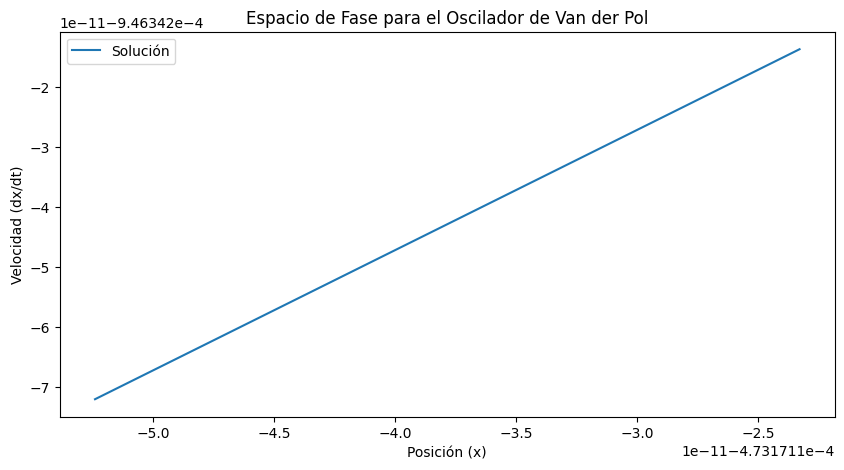

In [ ]:
# Resolver la ecuación diferencial usando el modelo entrenado
solution = model.predict(y_train_input)

# Visualizar la solución en el espacio de fase
plt.figure(figsize=(10, 5))
plt.plot(solution[:, 0], van_der_pol(solution[:, 0], mu), label='Solución')
plt.title('Espacio de Fase para el Oscilador de Van der Pol')
plt.xlabel('Posición (x)')
plt.ylabel('Velocidad (dx/dt)')
plt.legend()
plt.show()